# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. **Get the Bragg disks**
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 2: Get the Bragg disks

In this step the Bragg disks are located, as follows:

* For each diffraction pattern:
    * Cross correlate (or hybrid cross-phase correlate) the DP with the probe kernel
    * Get a first guess at Bragg disk positions by identifying positions and intensities of all local maxima
    * Filter out erroneous peaks by removing those too close together, in order of decreasing intensity
* Save Bragg disks list

### Import packages, load data

In [6]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected, find_Bragg_disks
from py4DSTEM.process.datastructure import PointList, PointListArray
from py4DSTEM.readwrite import FileBrowser, read, append

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution                       DiffractionSlice    
   2    probe_kernel                        DiffractionSlice    
   3    DF_image                            RealSlice           
   4    realslice_0                         RealSlice           
   5    strain_maps                         RealSlice           
   6    uv_map                              RealSlice           
   7    lattice_vectors                     PointList           
   8    Braggpeaks                          PointListArray      
   9    shifted_Braggpeaks                  PointListArray      


In [3]:
# Load data

dc = browser.get_dataobject('datacube')
probe_kernel = browser.get_dataobject('probe_kernel')
browser.close()

### Test parameters on a few diffraction patterns

Analyzed 3 diffraction patterns in 0h 0m 0s


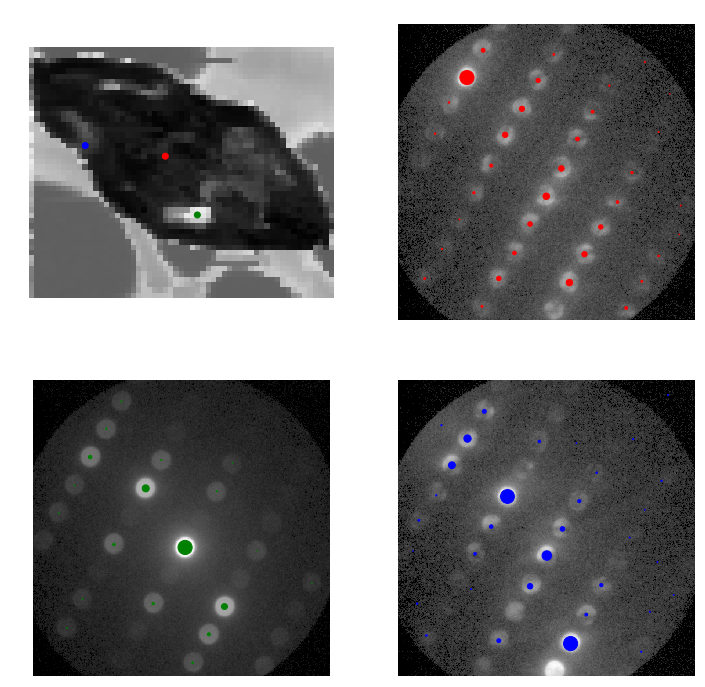

In [8]:
######## Parameters ########

# Select scan positions
Rxs=(20,31,18)
Rys=(25,31,10)

# Peak detection parameters
corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001

# Display parameters
power=0.3
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel.data2D, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data4D[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data4D[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data4D[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Find Bragg disks in all diffraction patterns

In [9]:
######## Parameters ########

corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001
verbose = True

############################

peaks = find_Bragg_disks(dc, probe_kernel.data2D,
                         corrPower=corrPower,
                         sigma=sigma,
                         edgeBoundary=edgeBoundary,
                         minRelativeIntensity=minRelativeIntensity,
                         minPeakSpacing=minPeakSpacing,
                         maxNumPeaks=maxNumPeaks,
                         verbose=verbose)

TypeError: __init__() missing 1 required positional argument: 'shape'

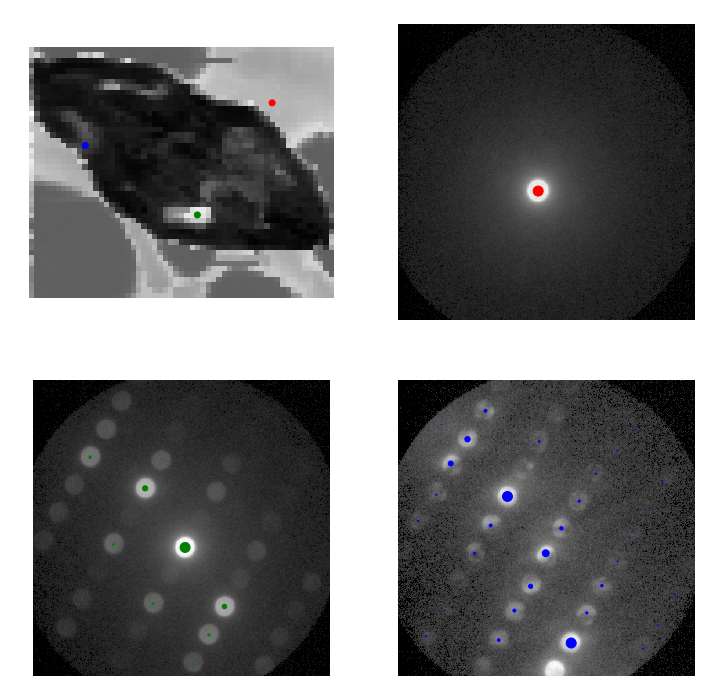

In [8]:
# Show results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeak_pointlistarray.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeak_pointlistarray.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeak_pointlistarray.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

In [9]:
# Copy Bragg peaks pointlistarray, to further threshold detected peaks

Braggpeak_pointlistarray_refined = Braggpeak_pointlistarray.copy(name='Braggpeaks')

In [10]:
# Remove points based on new peak spacing or minimum relative intensity thresholds

maxNumPeaks = 60
minPeakSpacing = 50
minRelativeIntensity = 0.0005

for Rx in range(dc.R_Nx):
     for Ry in range(dc.R_Ny):

        point_list = Braggpeak_pointlistarray_refined.get_pointlist(Rx,Ry)

        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,point_list.length)
        point_list.sort(coordinate='intensity',order='descending')
        deletePeaks = np.zeros(point_list.length, bool)
        deletePeaks[numPeaks:] = True
        point_list.remove_points(deletePeaks) 
        
        # Remove peaks that are too close together
        point_list.sort(coordinate='intensity',order='descending')
        numPeaks = min(maxNumPeaks,point_list.length)
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
        
        # Remove peaks below minRelativeIntensity threshold
        deletemask = point_list.data['intensity']/max(point_list.data['intensity']) < minRelativeIntensity
        point_list.remove_points(deletemask)

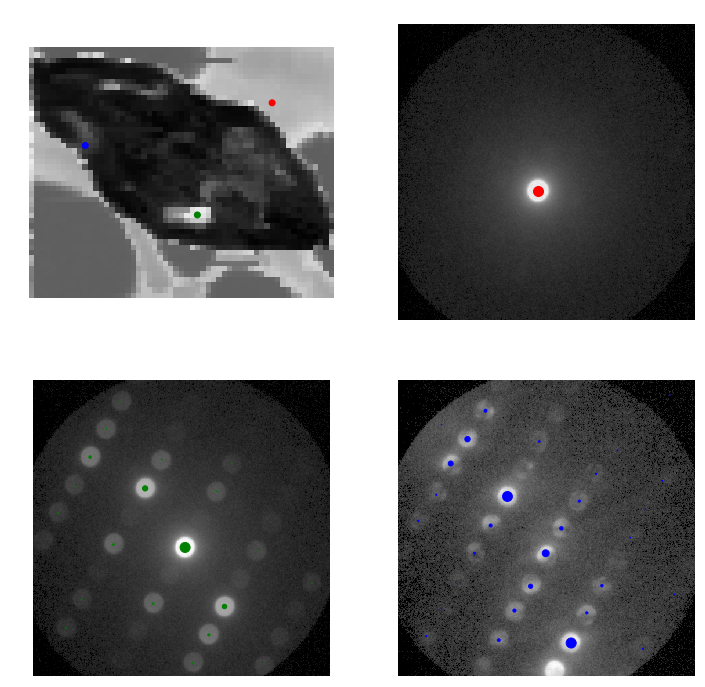

In [11]:
# Show newly thresholded results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Braggpeak_pointlistarray_refined.get_pointlist(xs[0],ys[0])
peaks1 = Braggpeak_pointlistarray_refined.get_pointlist(xs[1],ys[1])
peaks2 = Braggpeak_pointlistarray_refined.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Save Bragg disk list

In [12]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(Braggpeak_pointlistarray_refined, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
